# 0. Preparation

In [2]:
if 'google.colab' in str(get_ipython()):
    IN_COLLAB = True
else:
    IN_COLLAB = False

if IN_COLLAB:
    #TODO: CHANGE THIS BASED ON YOUR OWN LOCAL SETTINGS
    MY_HOME_ABS_PATH = "/content/drive/MyDrive/W210/co2-flux-hourly-gpp-modeling"
    from google.colab import drive
    drive.mount('/content/drive/')
else:
    MY_HOME_ABS_PATH = "/root/co2-flux-hourly-gpp-modeling/"

## Import libraries

In [3]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")
import copy
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pytorch_lightning as pl
import torch
import torch.nn as nn

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting import BaseModel, MAE
from pytorch_forecasting.metrics.point import RMSE
from pytorch_forecasting.data.encoders import NaNLabelEncoder

from sklearn.metrics import r2_score
from timeit import default_timer
from tqdm import tqdm
from datetime import datetime
import gc
import pickle

# Load locale custome modules
os.chdir(MY_HOME_ABS_PATH)
if IN_COLLAB:
     sys.path.insert(0,os.path.abspath("./code/src/tools"))
else:
    sys.path.append('./.cred')
    sys.path.append('./code/src/tools')
    sys.path.append(os.path.abspath("./code/src/tools"))

from CloudIO.AzStorageClient import AzStorageClient
from data_pipeline_lib import *
from model_pipeline_lib import *

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pl.seed_everything(42)
plt.rcParams['figure.figsize'] = [6, 12]

2023-04-16 04:43:46.156959: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-16 04:43:46.159260: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-16 04:43:46.206195: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-16 04:43:46.206934: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-16 04:43:46.956343: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [4]:
def setup_tsdataset_nogpp_full(train_df, val_df, test_df, min_encoder_len):
    training = TimeSeriesDataSet(
      train_df,
      time_idx="timestep_idx_global",
      target="GPP_NT_VUT_REF",
      group_ids=["site_id"],
      allow_missing_timesteps=False,
      min_encoder_length=min_encoder_len,
      max_encoder_length=min_encoder_len,
      min_prediction_length=1,
      max_prediction_length=1,
      static_categoricals=["MODIS_IGBP","koppen_main","koppen_sub"],
      static_reals=[],
      time_varying_known_categoricals=["month", "hour"],
      time_varying_known_reals=["timestep_idx_global", 
                                'TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA',
                                'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 
                                'BESS-PAR', 'BESS-PARdiff', 'BESS-RSDN', 'CSIF-SIFdaily', 'PET', 'Ts', 
                                'ESACCI-sm', 'NDWI', 'Percent_Snow', 'Fpar', 'Lai', 'LST_Day','LST_Night'],
      time_varying_unknown_categoricals=["gap_flag_month", "gap_flag_hour"], 
      time_varying_unknown_reals=[],
      target_normalizer=None,
      categorical_encoders={'MODIS_IGBP': NaNLabelEncoder(add_nan=True),
                            'koppen_main': NaNLabelEncoder(add_nan=True),
                            'koppen_sub': NaNLabelEncoder(add_nan=True),
                            },
      add_relative_time_idx=True,
      add_target_scales=False,
      add_encoder_length=False,
    )

    validation = TimeSeriesDataSet.from_dataset(training, val_df, predict=False, stop_randomization=True)
    
    if test_df is not None:
        testing = TimeSeriesDataSet.from_dataset(training, test_df, predict=False, stop_randomization=True)
    else:
        testing = None

    return (training, validation, testing)


def setup_tsdataset_nogpp_new_slim(train_df, val_df, test_df, min_encoder_len):
    training = TimeSeriesDataSet(
      train_df,
      time_idx="timestep_idx_global",
      target="GPP_NT_VUT_REF",
      group_ids=["site_id"],
      allow_missing_timesteps=False,
      min_encoder_length=min_encoder_len,
      max_encoder_length=min_encoder_len,
      min_prediction_length=1,
      max_prediction_length=1,
      static_categoricals=[],
      static_reals=[],
      time_varying_known_categoricals=["month", "hour"],
      time_varying_known_reals=['SW_IN_ERA', 'LW_IN_ERA', 'b1', 'b2', 'b5', 'b6', 'b7', 'ESACCI-sm', 'NDWI', 'TA_ERA', 'BESS-PARdiff', 'NDVI', 'PET', 'NIRv', 'PA_ERA', 'VPD_ERA', 'P_ERA', 'timestep_idx_global'],
      time_varying_unknown_categoricals=["gap_flag_month", "gap_flag_hour"], 
      time_varying_unknown_reals=[],
      target_normalizer=None,
      categorical_encoders={},
      add_relative_time_idx=True,
      add_target_scales=False,
      add_encoder_length=False,
    )

    validation = TimeSeriesDataSet.from_dataset(training, val_df, predict=False, stop_randomization=True)
    
    if test_df is not None:
        testing = TimeSeriesDataSet.from_dataset(training, test_df, predict=False, stop_randomization=True)
    else:
        testing = None

    return (training, validation, testing)



def setup_tsdataset_nogpp_slim(train_df, val_df, test_df, min_encoder_len):
    training = TimeSeriesDataSet(
      train_df,
      time_idx="timestep_idx_global",
      target="GPP_NT_VUT_REF",
      group_ids=["site_id"],
      allow_missing_timesteps=False,
      min_encoder_length=min_encoder_len,
      max_encoder_length=min_encoder_len,
      min_prediction_length=1,
      max_prediction_length=1,
      static_categoricals=["MODIS_IGBP","koppen_main"],
      static_reals=[],
      time_varying_known_categoricals=["month", "hour"],
      time_varying_known_reals=['TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA',
                                'EVI', 'NDVI', 'NIRv', 'BESS-RSDN',],
      time_varying_unknown_categoricals=["gap_flag_month", "gap_flag_hour"], 
      time_varying_unknown_reals=[],
      target_normalizer=None,
      categorical_encoders={'MODIS_IGBP': NaNLabelEncoder(add_nan=True),
                            'koppen_main': NaNLabelEncoder(add_nan=True),
                            },
      add_relative_time_idx=True,
      add_target_scales=False,
      add_encoder_length=False,
    )

    validation = TimeSeriesDataSet.from_dataset(training, val_df, predict=False, stop_randomization=True)
    
    if test_df is not None:
        testing = TimeSeriesDataSet.from_dataset(training, test_df, predict=False, stop_randomization=True)
    else:
        testing = None

    return (training, validation, testing)


def setup_tsdataset_nogpp_slim_30D(train_df, val_df, test_df, min_encoder_len):
    training = TimeSeriesDataSet(
      train_df,
      time_idx="timestep_idx_global",
      target="GPP_NT_VUT_REF",
      group_ids=["site_id"],
      allow_missing_timesteps=False,
      min_encoder_length=min_encoder_len,
      max_encoder_length=min_encoder_len,
      min_prediction_length=1,
      max_prediction_length=1,
      static_categoricals=["MODIS_IGBP","koppen_main"],
      static_reals=[],
      time_varying_known_categoricals=["month", "hour"],
      time_varying_known_reals=["timestep_idx_global", 'TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA',
                                'EVI', 'NDVI', 'NIRv', 'BESS-RSDN',],
      time_varying_unknown_categoricals=["gap_flag_month", "gap_flag_hour"], 
      time_varying_unknown_reals=[],
      target_normalizer=None,
      categorical_encoders={'MODIS_IGBP': NaNLabelEncoder(add_nan=True),
                            'koppen_main': NaNLabelEncoder(add_nan=True),
                            },
      add_relative_time_idx=True,
      add_target_scales=False,
      add_encoder_length=False,
    )

    validation = TimeSeriesDataSet.from_dataset(training, val_df, predict=False, stop_randomization=True)
    
    if test_df is not None:
        testing = TimeSeriesDataSet.from_dataset(training, test_df, predict=False, stop_randomization=True)
    else:
        testing = None

    return (training, validation, testing)


def get_preds_actuals_agg(dataloader):
    # Get preds for site
    preds_q = best_tft.predict(dataloader, mode="quantiles", return_x=False)
    
    # Get actuals and mask from dataloader
    actuals_list = []
    mask_list = []
    for x, y in iter(dataloader):
        actuals_list.append(y[0])
        mask_list.append(x['x_cat'][-1, -1].reshape(-1))
    actuals = torch.cat(actuals_list)
    mask = torch.logical_not(torch.cat(mask_list))

    # Reshape
    actuals = actuals.reshape(-1)
    
    return preds_q, actuals, mask


def get_eval_metrics_simple(y_true, y_pred, mask=None):    
    # Apply mask if there is any
    if mask is not None:            
        y_true = y_true[mask.bool()]
        y_pred = y_pred[mask.bool()]

    rmse = torch.sqrt(torch.mean((y_true - y_pred) ** 2)).item()
    mae = torch.mean((y_true - y_pred).abs()).item()
    nse = nash_sutcliffe(y_true, y_pred).item()
    
    return rmse, mae, nse

# Load data from Azure blob

In [5]:
root_dir =  MY_HOME_ABS_PATH
tmp_dir =  root_dir + os.sep + '.tmp'
model_dir = root_dir + os.sep + 'data' + os.sep + 'models'
cred_dir = root_dir + os.sep + '.cred'
az_cred_file = cred_dir + os.sep + 'azblobcred.json'

# Download full data
container = "all-sites-data"
blob_name = "full_2010_2015_v_mvp_raw.parquet"

data_df = get_raw_datasets(container, blob_name)

Data size: (4862712, 51)
Data Columns: Index(['GPP_NT_VUT_REF', 'site_id', 'timestep_idx_local',
       'timestep_idx_global', 'datetime', 'date', 'year', 'month', 'day',
       'hour', 'TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA',
       'PA_ERA', 'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6',
       'b7', 'IGBP', 'lat', 'long', 'koppen_sub', 'koppen_main', 'c3c4',
       'c4_percent', 'BESS-PAR', 'BESS-PARdiff', 'BESS-RSDN', 'CSIF-SIFdaily',
       'PET', 'Ts', 'ESACCI-sm', 'MODIS_LC', 'NDWI', 'Percent_Snow', 'Fpar',
       'Lai', 'LST_Day', 'LST_Night', 'MODIS_IGBP', 'MODIS_PFT',
       'gap_flag_hour', 'gap_flag_month'],
      dtype='object')
NA count: 0


In [6]:
# Experiment constants
VAL_INDEX  = 3
TEST_INDEX = 4
SUBSET_LEN = 24*365*5

train_df, val_df, test_df = get_splited_datasets(data_df, VAL_INDEX, TEST_INDEX)
train_df, val_df, test_df = subset_data(train_df, val_df, test_df, SUBSET_LEN)

# create dataloaders for model
batch_size = 256 
cpu_count = os.cpu_count()

Subest length: 43800 timesteps for each sites
Subset num train timesteps: 2579424
Subset num val timesteps: 952752
Subset num test timesteps: 891744


# Define Constants, Functions

In [7]:
# Select split to evaluate
eval_split = 'test'

# Define model dirs
model_dirs = [
    "tft_model_14_1_5YrTrain_3DEncode_SmallNetwork_TopFeatures_NoGPP_230402_2227",
    "tft_model_16_tft_nogpp_7D_small_lr_230406_0405",
    "tft_model_18_tft_nogpp_14D_small_lr_230409_1755",
    "tft_model_5YrTrain_30DEncode_SmallNetwork_Top7Features_NoGPP_230402_1700"
]
names = [
    '14_1',
    '16', 
    '18',
    '14_4',
]

# Define corresponding encoder lengths for model
enc_lengths = [
   3, 
   7, 
   14,
   30
]

loaders = [
    "setup_tsdataset_nogpp_slim", 
    "setup_tsdataset_nogpp_slim", 
    "setup_tsdataset_nogpp_slim",
    "setup_tsdataset_nogpp_slim_30D", 
]

## Load Eval Result

In [8]:
for i in range(len(model_dirs)):
    try:
        # Load best models
        print(f"\n\n-------- BEGIN ROUND: {names[i]}--------")
        model_dir = model_dirs[i]
        exp_model_dir = f"/root/co2-flux-hourly-gpp-modeling/data/models/{model_dir}"

        # get raw predictions
        try:
            print("Loading avg attn tensors from previous eval script")
            var_name = f"enc_attn_avg_{i}"
            with open(exp_model_dir + os.sep + f"{eval_split}_enc_attn_avg.pkl", "rb") as fin:
                globals()[var_name] = pickle.load(fin)
        except:
            print("****Unable to load avg attention. Running these now...")
            print(f"Loading best model - {names[i]}")
            
            checkpt_dir = f"{exp_model_dir}/lightning_logs/version_0/checkpoints/"
            checkpt = os.listdir(checkpt_dir)[-1]
            best_model_path = f"{checkpt_dir}{checkpt}"
            best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

            # Setup dataloaders
            ENCODER_LEN = 24*enc_lengths[i]
            if loaders[i] == "setup_tsdataset_nogpp_slim":
                train, validation, test = setup_tsdataset_nogpp_slim(train_df, val_df, test_df, ENCODER_LEN)
            elif loaders[i] == "setup_tsdataset_nogpp_slim_30D":
                train, validation, test = setup_tsdataset_nogpp_slim_30D(train_df, val_df, test_df, ENCODER_LEN)
            elif loaders[i] == "setup_tsdataset_nogpp_new_slim":
                train, validation, test = setup_tsdataset_nogpp_new_slim(train_df, val_df, test_df, ENCODER_LEN)

            # Select split to evaluate
            if eval_split == 'val':
                dataloader = validation
                split_df = val_df.copy()
            elif eval_split == 'test':
                dataloader = test
                split_df = test_df.copy()
                
            raw_preds = best_tft.predict(dataloader, mode="raw", return_x=False)
            enc_attn_avg = torch.mean(raw_preds['encoder_attention'], dim=0).squeeze()

            print("Saving now")
            with open(exp_model_dir + os.sep + f"{eval_split}_enc_attn_avg.pkl", "wb") as fout:
                pickle.dump(enc_attn_avg, fout)
                
    except:
        print(f"Issue w {names[i]}")
        continue



-------- BEGIN ROUND: 14_1--------
Loading avg attn tensors from previous eval script


-------- BEGIN ROUND: 16--------
Loading avg attn tensors from previous eval script


-------- BEGIN ROUND: 18--------
Loading avg attn tensors from previous eval script


-------- BEGIN ROUND: 14_4--------
Loading avg attn tensors from previous eval script


In [ ]:
# plot for now, replot later with tailored formating
for i in range(len(enc_lengths)):
    trim = 8
    ENCODER_LEN = 24*enc_lengths[i]
    var_name = f"enc_attn_avg_{i}"
    enc_attn_avg = globals()[var_name]
    print(f"attn_mean: {torch.mean(enc_attn_avg)}")

    attn_min = torch.min(enc_attn_avg)
    attn_max = enc_attn_avg[trim:].max()
    print(f"attn_max: {attn_max}")

    fig, ax = plt.subplots()
    ax.plot(range(-ENCODER_LEN, 0), enc_attn_avg)
    ax.set_ylim([attn_min-(attn_min*0.05), attn_max+(attn_max*0.05)])
    ax.set_xlim([-ENCODER_LEN+trim, 0])
    ax.set_xticks(np.arange(0, -ENCODER_LEN, -24))
    ax.set_ylabel('Attention')
    ax.set_xlabel('Encoder Index (Hours)')
    plt.xticks(rotation=45)
    plt.title(f'NO-GPP-TFT Attention: {enc_lengths[i]} Day Encoder Model')
    plt.show()

attn_mean: 0.0138888880610466
attn_max: 0.01432775892317295
attn_mean: 0.0059523810632526875
attn_max: 0.006469678599387407
attn_mean: 0.0029761905316263437
attn_max: 0.0032045801635831594
attn_mean: 0.0013888889225199819
attn_max: 0.00153849006164819


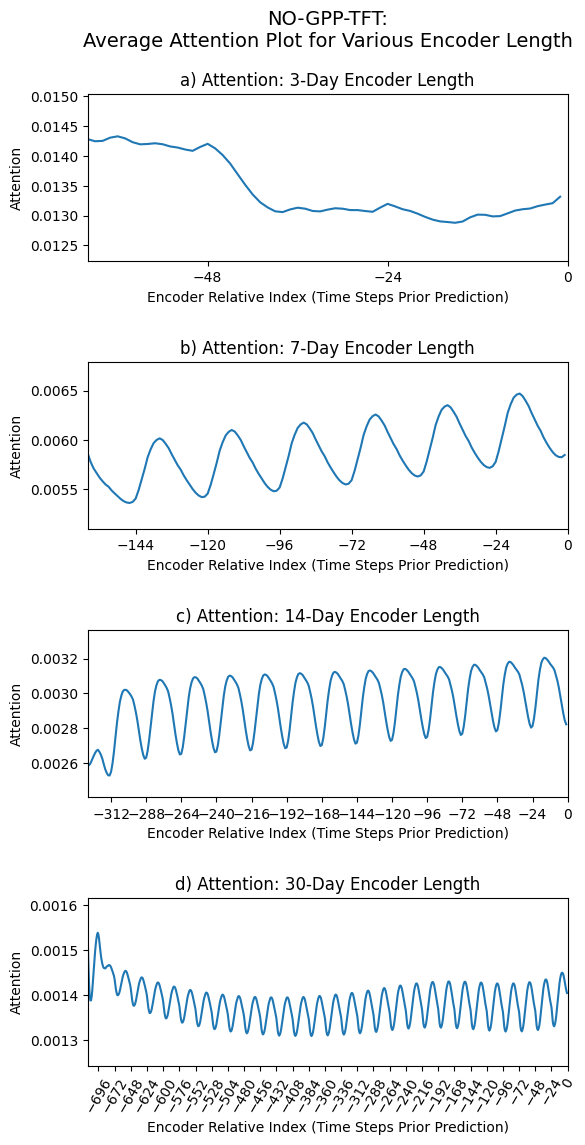

In [53]:
# Merge all into one plot
fig, ax = plt.subplots(nrows=len(enc_lengths), ncols=1)
labels = ['a)', 'b)', 'c)', 'd)']

for i in range(len(enc_lengths)):
    trim = 8
    ENCODER_LEN = 24*enc_lengths[i]
    var_name = f"enc_attn_avg_{i}"
    enc_attn_avg = globals()[var_name]
    print(f"attn_mean: {torch.mean(enc_attn_avg)}")

    attn_min = torch.min(enc_attn_avg)
    attn_max = enc_attn_avg[trim:].max()
    print(f"attn_max: {attn_max}")
    
    ax[i].plot(range(-ENCODER_LEN, 0), enc_attn_avg)
    ax[i].set_ylim([attn_min-(attn_min*0.05), attn_max+(attn_max*0.05)])
    ax[i].set_xlim([-ENCODER_LEN+trim, 0])
    ax[i].set_xticks(np.arange(0, -ENCODER_LEN+1, -24))
    ax[i].set_ylabel('Attention')
    ax[i].set_xlabel('Encoder Relative Index (Time Steps Prior Prediction)')
    ax[i] .set_title(f'{labels[i]} Attention: {enc_lengths[i]}-Day Encoder Length', fontsize=12)

plt.subplots_adjust( left=0.1, bottom=0.1,  right=0.9,  top=0.91,   wspace=0.4, hspace=0.6)
    
plt.xticks(rotation=60)
plt.suptitle(f'NO-GPP-TFT:\nAverage Attention Plot for Various Encoder Length', fontsize=14)
plt.show()

# GPP-TFT

In [9]:
def setup_tsdataset_gpptft(train_df, val_df, test_df, min_encoder_len):
    # create training and validation TS dataset 
    training = TimeSeriesDataSet(
      train_df,
      time_idx="timestep_idx_global",
      target="GPP_NT_VUT_REF",
      group_ids=["site_id"],
      allow_missing_timesteps=False, # <---- turned on bc some rows are removed.
      min_encoder_length=min_encoder_len,
      max_encoder_length=min_encoder_len,
      min_prediction_length=1,
      max_prediction_length=1,
      static_categoricals=["MODIS_IGBP","koppen_main","koppen_sub"],
      static_reals=[],
      time_varying_known_categoricals=["month", "day", "hour"],
      time_varying_known_reals=["timestep_idx_global", 
                                'TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA',
                                'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 
                                'BESS-PAR', 'BESS-PARdiff', 'BESS-RSDN', 'CSIF-SIFdaily', 'PET', 'Ts', 
                                'ESACCI-sm', 'NDWI', 'Percent_Snow', 'Fpar', 'Lai', 'LST_Day','LST_Night'],
      time_varying_unknown_categoricals=["gap_flag_month", "gap_flag_hour"], 
      time_varying_unknown_reals=["GPP_NT_VUT_REF"],
      target_normalizer=None,
      categorical_encoders={'MODIS_IGBP': NaNLabelEncoder(add_nan=True),
                            'koppen_main': NaNLabelEncoder(add_nan=True),
                            'koppen_sub': NaNLabelEncoder(add_nan=True),
                            'year': NaNLabelEncoder(add_nan=True),
                            },
      add_relative_time_idx=True,
      add_target_scales=False, # <------- turned off
      add_encoder_length=False, # <------- turned off
    )

    validation = TimeSeriesDataSet.from_dataset(training, val_df, predict=False, stop_randomization=True)
    
    if test_df is not None:
        testing = TimeSeriesDataSet.from_dataset(training, test_df, predict=False, stop_randomization=True)
    else:
        testing = None

    return (training, validation, testing)

attn_mean: 0.0029761905316263437
attn_max: 0.017858732491731644


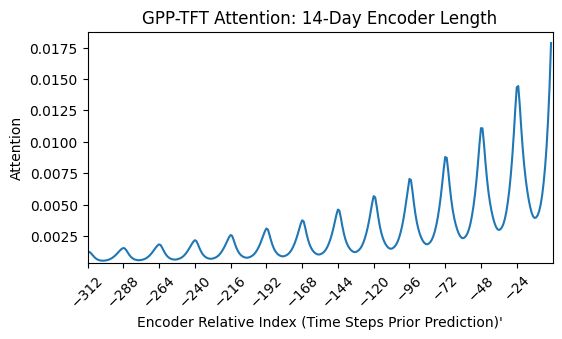

In [31]:
trim = 24
attention = interpretation["attention"].detach().cpu()
attention = attention / attention.sum(-1).unsqueeze(-1)
print(f"attn_mean: {torch.mean(attention)}")

attn_min = torch.min(attention)
attn_max = attention[trim:].max()
print(f"attn_max: {attn_max}")

fig, ax = plt.subplots(figsize=(6,3))
ax.plot(range(-ENCODER_LEN, 0), attention)
ax.set_ylim([attn_min-(attn_min*0.05), attn_max+(attn_max*0.05)])
ax.set_xlim([-ENCODER_LEN+trim, 0])
ax.set_xticks(np.arange(-ENCODER_LEN+trim,0 , 24))
ax.set_ylabel('Attention')
ax.set_xlabel("Encoder Relative Index (Time Steps Prior Prediction)'")
plt.xticks(rotation=45)
plt.title(f'GPP-TFT Attention: 14-Day Encoder Length')
plt.show()